# Machine Learning for Security Analysts - Workbook </br> Spam Filter (Naive Bayes)

---


Author: GTKlondike
</br>
Email: GTKlondike@gmail.com
</br>
YouTube: [NetSec Explained](https://www.youtube.com/channel/UCsKK7UIiYqvK35aWrCCgUUA)

**Dataset:** https://github.com/NetsecExplained/Machine-Learning-for-Security-Analysts

**Goal:** This workbook will walk you through the steps to build, train, test, and evaluate a Naive Bayes spam classifier from the ground up

**Outline:** 
* Initial Setup
* Tokenization
* Load Training Data
* Create Predict Function
* Test and Evaluate Models


## Instructions
To use Jupyter notebooks:
* To run a cell, click on the play button to the left of the code or pressh shift+enter
* You will see a busy indicator in the top left area while the runtime is executing
* A number will appear when the cell is done

# Initial Setup
We'll start by downloading the data and loading the needed libraries.

In [0]:
# Download data from Github
! git clone https://github.com/NetsecExplained/Machine-Learning-for-Security-Analysts.git
  
# Install dependencies
! pip install nltk sklearn pandas matplotlib seaborn
data_dir = "Machine-Learning-for-Security-Analysts"

fatal: destination path 'Machine-Learning-for-Security-Analysts' already exists and is not an empty directory.


In [0]:
# Common imports
import re, os, math, string, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import re

# Import Seaborn heatmap graphs
import seaborn as sns

%matplotlib inline

# Import Natural Language ToolKit library and download dictionaries
import nltk
nltk.download('stopwords')
nltk.download('punkt')

print("\n### Libraries Imported ###\n")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!

### Libraries Imported ###



In [0]:
# Test email from lecture slides
test_email = """
Re: Re: East Asian fonts in Lenny. Thanks for your support.  Installing unifonts did it well for me. ;)
Nima
--
To UNSUBSCRIBE, email to debian-user-REQUEST@lists.debian.org
with a subject of "unsubscribe". Trouble? Contact listmaster@lists.debian.org
"""
print(test_email)


Re: Re: East Asian fonts in Lenny. Thanks for your support.  Installing unifonts did it well for me. ;)
Nima
--
To UNSUBSCRIBE, email to debian-user-REQUEST@lists.debian.org
with a subject of "unsubscribe". Trouble? Contact listmaster@lists.debian.org



# Tokenization
Continuing from where we left off with the slides, we'll start by creating our tokenizer.

In [0]:
# Define tokenizer
#   The purpose of a tokenizer is to separate the features from the raw data

def tokenizer(text):
  """Separates feature words from the raw data
  Keyword arguments:
    text ---- The full email body
    
  :Returns -- The tokenized words; returned as a list
  """
  
  # Retrieve a list of punctuation characters, a list of stopwords, and a stemmer function
  punctuations = list(string.punctuation)
  stopwords = nltk.corpus.stopwords.words('english')
  stemmer = nltk.stem.PorterStemmer()
  
  
  # Set email body to lowercase, separate words and strip out punctuation
  tokens = nltk.word_tokenize(text.lower())
  tokens = [i.strip(''.join(punctuations)) 
            for i in tokens 
            if i not in punctuations]
  
  
  # User Porter Stemmer on each token
  tokens = [stemmer.stem(i)
            for i in tokens]
  return [w for w in tokens if w not in stopwords and w != ""]


print("\n### Tokenizer defined ###\n")


### Tokenizer defined ###



In [0]:
# Let's see how our tokenizer changes our email
print("\n- Test Email Body -\n")
print(test_email)

# Tokenize test email
print("\n - Tokenized Output -\n")
tokenized_email = tokenizer(test_email)
print(tokenized_email)


- Test Email Body -


Re: Re: East Asian fonts in Lenny. Thanks for your support.  Installing unifonts did it well for me. ;)
Nima
--
To UNSUBSCRIBE, email to debian-user-REQUEST@lists.debian.org
with a subject of "unsubscribe". Trouble? Contact listmaster@lists.debian.org


 - Tokenized Output -

['east', 'asian', 'font', 'lenni', 'thank', 'support', 'instal', 'unifont', 'well', 'nima', 'unsubscrib', 'email', 'debian-user-request', 'lists.debian.org', 'subject', 'unsubscrib', 'troubl', 'contact', 'listmast', 'lists.debian.org']


In [0]:
# Define email reader
 
def readEmail(email):
  """Reads an email and returns word counts
  Keyword arguments:
    email --- The email body to be read

  :Returns -- The count of each word; returned as a dict
           -- The total number of words; returned as a int
  """
  
  # Retrieve list of tokens
  words = tokenizer(email)
  
  # Build table
  table = dict.fromkeys(words, 0)
  for word in words:
    table[word] += 1
    
  # Get word count
  word_count = len(words)

  return table, word_count


print("\n### Email Reader Defined ###\n")


### Email Reader Defined ###



In [0]:
# Let's see how readEmail interprets our test email
test_email_words, test_email_wordcount = readEmail(test_email)

print("\n- Word Counts -\n")
for i in test_email_words.keys():
  print("{} - {}".format(test_email_words[i], i))

print("\n- Total Words in Email -\n")
print("{} - Total".format(test_email_wordcount))


- Word Counts -

1 - east
1 - asian
1 - font
1 - lenni
1 - thank
1 - support
1 - instal
1 - unifont
1 - well
1 - nima
2 - unsubscrib
1 - email
1 - debian-user-request
2 - lists.debian.org
1 - subject
1 - troubl
1 - contact
1 - listmast

- Total Words in Email -

20 - Total


# Load Training Data
With our tokenizer defined, let's take a look at our training data.

In [0]:
# 5 things to keep track of:

#   1. The NUMBER of unique words
#     This will be calculated as everything is loaded
unique_words_table = set()


#   2. The TOTAL NUMBER of words in Spam
#   3. The TOTAL NUMBER of words in Ham
spam_table_len = 0
ham_table_len = 0


#   4. The COUNT of each word in Spam
#   5. the COUNT of each word in Ham
spam_table = dict()
ham_table = dict()


print("\n### Initialized Feature Tables ###\n")


### Initialized Feature Tables ###



In [0]:
# Define Spam learning

def learnSpam(email):
  """Reads an email, updates Spam table and word counts
  Keyword arguments:
    email --- The email body to be read

  :Returns -- N/A
  """
  
  # Include global variables
  global spam_table
  global spam_table_len
  global unique_words_table

  # Read the email
  table, word_count = readEmail(email)

  # Add UNIQUE words
  unique_words_table.update(table)

  # Add word count to TOTAL number of Spam words
  spam_table_len += word_count

  # Add word counts to Spam table
  for word in table:
    spam_table.setdefault(word, 0)
    spam_table[word] += table[word]
    
    
print("\n### Spam Learner Defined ###\n")


### Spam Learner Defined ###



In [0]:
# Define Ham learning

def learnHam(email):
  """Reads an email, updates Ham table and word counts
  Keyword arguments:
    email --- The email body to be read

  :Returns -- N/A
  """
  
  # Include global variables
  global ham_table
  global ham_table_len
  global unique_words_table

  # Read the email
  table, word_count = readEmail(email)

  # Add UNIQUE words
  unique_words_table.update(table)

  # Add word count to TOTAL number of Ham words
  ham_table_len += word_count

  # Add word counts to Ham table
  for word in table:
    ham_table.setdefault(word, 0)
    ham_table[word] += table[word]
    

print("\n### Ham Learner Defined ###\n")


### Ham Learner Defined ###



In [0]:
# Load the training data

# Store count for calculating priors
spam_count = 0
ham_count = 0

# Load all of the emails from the "ham" directory
print("- Training Ham -")
for each in os.listdir(data_dir + '/ham'):
  with open(data_dir + '/ham/' + each, 'r') as f:
    learnHam(f.read())
  ham_count += 1
    

# Load all of the emails from the "spam" directory
print("- Training Spam -")
for each in os.listdir(data_dir + '/spam'):
  with open(data_dir + '/spam/' + each, 'r') as f:
    learnSpam(f.read())
  spam_count += 1

print("\n### Training complete ###\n")

- Training Ham -
- Training Spam -

### Training complete ###



In [0]:
# Let's see how our spam_table looks
showfirstK = 15
print("- Showing First {} Elements -".format(showfirstK))

for i in list(spam_table):
  print("{} \t- {}".format(spam_table[i], i))
  showfirstK -= 1
  if showfirstK <= 0:
    break

- Showing First 15 Elements -
34 	- hello
2 	- rsharp2
25 	- winner
6 	- bahama
19 	- bound
96 	- dear
7 	- congratul
1 	- your
2 	- youv
40 	- chanc
778 	- receiv
44 	- expens
57 	- paid
17 	- florida
20 	- vacat


# Create Predict Function
Now that the training data has been loaded, let's create a repeatable function that can perform predictions.


In [0]:
# Define the predict function

def predict(email, alpha=1, print_probs=False):
  """Reads an email, updates Ham table and word counts
  Keyword arguments:
    email -------- The email body to be read
    alpha -------- Smoothing alpha to be applied (almost always 1)
    print_probs -- Print probabilities for debugging purposes

  :Returns ------- The predicted class label; as a str
  """
  
  # Read the email
  tokens = tokenizer(email)

  # Retrieve N from (1. The NUMBER of unique words)
  N = len(unique_words_table)
  
  # Calculate priors - P(spam) and P(ham)
  spam_prior = spam_count / (spam_count + ham_count)
  ham_prior  =  ham_count / (spam_count + ham_count)
  
  # Retrieve denominator values for Spam and Ham calculations
  spam_denominator = spam_table_len + N*alpha
  ham_denominator = ham_table_len + N*alpha
  
  
  
  # Calculate the numerators
  spam_numerator = 1
  ham_numerator = 1
  
  for word in tokens:
    
    # Set to 0 incase word doesn't exist
    spam_table.setdefault(word, 0)
    ham_table.setdefault(word, 0)
    
    spam_numerator *= spam_table[word] + alpha
    ham_numerator *=  ham_table[word] + alpha
  
  
  
  # Calculate the probabilities
  #   Using log properties to prevent overflows/underflows  
  spam_probability = math.log(spam_prior) + (math.log(spam_numerator) - math.log(spam_denominator ** len(tokens)))
  ham_probability  = math.log(ham_prior) + (math.log( ham_numerator) - math.log( ham_denominator ** len(tokens)))

  
  
  # Print probabilities for debugging purposes
  if print_probs == True:
    print("- Probabilities -")
    print("Spam Probability: {}".format(spam_probability))
    print("Ham Probability:  {}".format(ham_probability))
  
  
  # Make classification decision
  if (spam_probability > ham_probability):
    return "spam"
  else:
    return "ham"
  

print("\n### Prediction Function Defined ###\n")


### Prediction Function Defined ###



In [0]:
# Predict our test email
test_email_prediction = predict(test_email, print_probs=True)
print("\n- Predicted Class -\n")
print("This email is classified as: {}".format(test_email_prediction))
print("\n- Email Body -\n")
print(test_email)

- Probabilities -
Spam Probability: -185.55705067716136
Ham Probability:  -148.1059806021724

- Predicted Class -

This email is classified as: ham

- Email Body -


Re: Re: East Asian fonts in Lenny. Thanks for your support.  Installing unifonts did it well for me. ;)
Nima
--
To UNSUBSCRIBE, email to debian-user-REQUEST@lists.debian.org
with a subject of "unsubscribe". Trouble? Contact listmaster@lists.debian.org



# Test and Evaluate the Model
OK, we have our training data loaded and a function to perform predictions. Now it's time to test and evaluate our model

But first, we're going to define a helper function to display our evaluation reports.

In [0]:
# Define report generator

def generate_report(cmatrix, score):
  """Generates and displays graphical reports
  Keyword arguments:
    cmatrix - Confusion matrix generated by the model
    score --- Score generated by the model
    
  :Returns -- N/A
  """
  
  # Generate confusion matrix heatmap
  plt.figure(figsize=(5,5))
  sns.heatmap(cmatrix, 
              annot=True, 
              fmt="d", 
              linewidths=.5, 
              square = True, 
              cmap = 'Blues', 
              annot_kws={"size": 16}, 
              xticklabels=['ham', 'spam'], 
              yticklabels=['ham', 'spam'])

  plt.xticks(rotation='horizontal', fontsize=16)
  plt.yticks(rotation='horizontal', fontsize=16)
  plt.xlabel('Actual Label', size=20);
  plt.ylabel('Predicted Label', size=20);

  title = 'Accuracy Score: {0:.4f}'.format(score)
  plt.title(title, size = 20);

  # Display confusion matrix
  plt.show()
  
  
print("\n### Report Generator Defined ###\n")


### Report Generator Defined ###



In [0]:
# Define a function to test the model

def testModel(alpha=1):
  """Evaluates the model with the given alpha
  Keyword arguments:
    alpha --- Smoothing alpha to be applied (almost always 1)

  :Returns -- N/A
  """
  
  # Initialize confusion matrix (true label vs predicted label)
  spam_spam = 0
  spam_ham  = 0
  ham_ham   = 0
  ham_spam  = 0
  
  
  # Predict testing emails
  print("- Predicting Testing Emails -")
  for filename in os.listdir(data_dir + '/test'):
      with open(data_dir + "/test/" + filename, 'r') as f:
          prediction = predict(f.read())
          true_label = re.split("txt\.", filename)[1]
          
          # Craft confusion matrix counts
          if (true_label == 'ham'):
            if (prediction == 'ham'):
              ham_ham += 1
            else:
              ham_spam += 1
          elif (true_label == 'spam'):
            if (prediction == 'spam'):
              spam_spam += 1
            else:
              spam_ham += 1
              
              
  # Calculate statistics
  cmatrix = [[ham_ham, spam_ham], 
             [ham_spam, spam_spam]]
  correctly_classified = ham_ham + spam_spam
  total_predictions   = ham_ham + spam_spam + ham_spam + spam_ham
  accuracy = float(correctly_classified) / total_predictions

  
  # Print testing statistics
  print("\n- Printing Test Statistics -\n")
  print("Total Emails: ", total_predictions)
  print("Correctly classified: ", correctly_classified)
  generate_report(cmatrix, accuracy)
  
  
print("\n### Model Evaluator Defined ###\n")


### Model Evaluator Defined ###



- Predicting Testing Emails -

- Printing Test Statistics -

Total Emails:  866
Correctly classified:  819


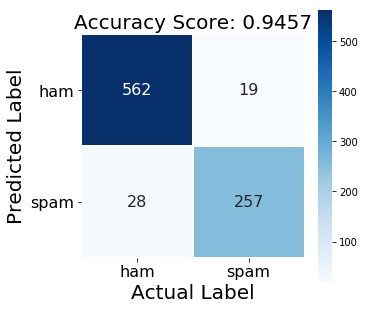

In [0]:
testModel()